In [1]:
from dotenv import load_dotenv

from pathlib import Path
import os 
import sys
import numpy as np
import json

load_dotenv()
GEMINI_KEY = os.getenv('GEMINI_KEY')

root = Path().resolve().parent

root_str = str(root)
if root_str not in sys.path:
    sys.path.insert(0, root_str)

if Path.cwd() != root:
    os.chdir(root)

# Results

In [2]:
import pandas as pd
import json
from pprint import pprint

results = json.load(open("results/bench_results.json"))

reshuffle = {}
for metric in ["is_valid", "correctness", "compliance"]:
    reshuffle[metric] = {
        model: {
            task: results[model][task][metric] if metric in results[model][task] else None
            for task in results[model]
        }
        for model in results
    }

def format_table(metric="is_valid", columns=None):
    df = pd.DataFrame(reshuffle[metric])
    if not columns:
        columns = df.columns
    df = df.loc[:, columns]
    return df.style.background_gradient(cmap="RdYlGn", vmin=0.2, vmax=1).format("{:.2f}")


for metric in ["is_valid", "compliance", "correctness"]:
    print("-"*100)
    print(metric)
    display(format_table(metric))
    print("\n")

----------------------------------------------------------------------------------------------------
is_valid


,gemini-2.5-flash,gemini-2.5-flash_jsonmode,gemini-2.5-flash_jsonmode_low,gemini-2.5-flash_low,gemini-2.5-pro,gemma-3-12b-it,gemma-3-12b-it_low,gemma-3-12b-it_vllm,gemma-3-12b-it_vllm_outlines,gemma-3-1b-it,gemma-3-1b-it_vllm,gemma-3-1b-it_vllm_outlines,gemma-3-27b-it,gemma-3-4b-it,gemma-3-4b-it_low,gemma-3-4b-it_transformers,gemma-3-4b-it_transformers_guidance,gemma-3-4b-it_transformers_outlines,gemma-3-4b-it_transformers_reasoning_free,gemma-3-4b-it_vllm,gemma-3-4b-it_vllm_outlines
1-rotowire,0.90,1.00,1.00,1.00,0.90,0.90,0.90,0.00,0.25,0.81,0.00,0.95,0.90,0.90,0.90,0.05,0.70,1.00,nan,0.81,0.02
2-wiki_bio,1.00,1.00,1.00,0.92,0.90,0.73,0.62,0.01,0.29,0.50,0.00,0.98,0.69,0.83,0.84,0.05,1.00,1.00,nan,0.89,0.96
3-few_nerd,0.93,1.00,1.00,0.96,0.90,0.90,0.90,0.00,0.01,0.00,0.00,0.89,0.90,0.90,0.90,0.06,1.00,0.07,nan,0.77,0.78
4-TOPv1,0.93,1.00,1.00,0.99,0.90,0.86,0.89,0.00,0.99,0.01,0.00,1.00,0.90,0.90,0.90,0.00,0.98,0.57,nan,0.00,1.00
5-api_bank,0.99,1.00,0.99,1.00,0.91,1.00,0.96,0.00,1.00,0.19,0.26,0.97,1.00,0.86,0.82,0.04,1.00,1.00,nan,0.42,0.94
6-reasoning/GSM8K,0.89,1.00,1.00,0.90,0.90,0.84,0.80,0.00,0.00,0.69,0.16,0.92,0.92,0.79,0.73,0.02,0.95,0.94,nan,0.74,0.98
6-reasoning/last_letter,0.90,1.00,1.00,0.90,0.90,0.90,0.66,0.00,0.00,0.98,0.00,1.00,0.90,0.90,0.00,0.00,1.00,1.00,nan,0.00,1.00




----------------------------------------------------------------------------------------------------
compliance


,gemini-2.5-flash,gemini-2.5-flash_jsonmode,gemini-2.5-flash_jsonmode_low,gemini-2.5-flash_low,gemini-2.5-pro,gemma-3-12b-it,gemma-3-12b-it_low,gemma-3-12b-it_vllm,gemma-3-12b-it_vllm_outlines,gemma-3-1b-it,gemma-3-1b-it_vllm,gemma-3-1b-it_vllm_outlines,gemma-3-27b-it,gemma-3-4b-it,gemma-3-4b-it_low,gemma-3-4b-it_transformers,gemma-3-4b-it_transformers_guidance,gemma-3-4b-it_transformers_outlines,gemma-3-4b-it_transformers_reasoning_free,gemma-3-4b-it_vllm,gemma-3-4b-it_vllm_outlines
1-rotowire,1.00,1.00,0.93,0.91,1.00,0.98,0.91,0.00,0.00,0.88,0.84,0.76,0.99,0.94,0.86,0.61,0.03,0.89,nan,0.89,0.01
2-wiki_bio,0.97,0.97,0.85,0.84,0.96,0.97,0.85,0.01,0.36,0.82,0.68,0.99,0.97,0.96,0.85,0.42,1.00,1.00,nan,0.96,1.00
3-few_nerd,1.00,1.00,1.00,1.00,1.00,0.99,1.00,0.00,0.00,0.75,0.63,0.00,1.00,1.00,1.00,0.92,1.00,0.92,nan,1.00,0.00
4-TOPv1,0.95,0.99,0.99,0.94,1.00,0.77,0.83,0.00,0.00,0.62,0.01,0.00,0.83,0.77,0.79,0.36,0.00,0.33,nan,0.33,0.00
5-api_bank,0.99,1.00,0.99,0.99,0.99,1.00,0.99,0.00,0.00,0.21,0.07,0.00,1.00,0.98,0.99,0.09,0.66,0.75,nan,0.87,0.00
6-reasoning/GSM8K,1.00,1.00,0.81,0.68,1.00,1.00,0.89,0.03,0.51,0.86,0.38,0.95,1.00,0.97,0.94,0.85,0.97,0.96,nan,0.91,0.99
6-reasoning/last_letter,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.01,0.50,1.00,0.49,1.00,1.00,1.00,1.00,0.49,1.00,1.00,nan,0.47,1.00




----------------------------------------------------------------------------------------------------
correctness


,gemini-2.5-flash,gemini-2.5-flash_jsonmode,gemini-2.5-flash_jsonmode_low,gemini-2.5-flash_low,gemini-2.5-pro,gemma-3-12b-it,gemma-3-12b-it_low,gemma-3-12b-it_vllm,gemma-3-12b-it_vllm_outlines,gemma-3-1b-it,gemma-3-1b-it_vllm,gemma-3-1b-it_vllm_outlines,gemma-3-27b-it,gemma-3-4b-it,gemma-3-4b-it_low,gemma-3-4b-it_transformers,gemma-3-4b-it_transformers_guidance,gemma-3-4b-it_transformers_outlines,gemma-3-4b-it_transformers_reasoning_free,gemma-3-4b-it_vllm,gemma-3-4b-it_vllm_outlines
1-rotowire,0.54,0.56,0.50,0.50,0.56,0.54,0.54,0.00,0.00,0.40,0.23,0.20,0.50,0.49,0.45,0.30,0.01,0.47,nan,0.45,0.00
2-wiki_bio,0.33,0.33,0.33,0.33,0.34,0.32,0.33,0.00,0.00,0.24,0.21,0.27,0.33,0.35,0.33,0.16,0.35,0.35,nan,0.35,0.28
3-few_nerd,0.60,0.58,0.59,0.59,0.55,0.40,0.40,0.00,0.00,0.23,0.16,0.00,0.39,0.43,0.40,0.40,0.42,0.35,nan,0.43,0.01
4-TOPv1,0.64,0.65,0.63,0.63,0.66,0.50,0.56,0.00,0.00,0.25,0.00,0.00,0.60,0.51,0.50,0.22,0.12,0.21,nan,0.21,0.00
5-api_bank,0.92,0.91,0.90,0.91,0.91,0.81,0.78,0.00,0.00,0.32,0.12,0.00,0.82,0.80,0.81,0.08,0.63,0.64,nan,0.69,0.00
6-reasoning/GSM8K,0.93,0.92,0.59,0.42,0.94,0.89,0.79,0.00,0.00,0.32,0.04,0.09,0.91,0.84,0.76,0.67,0.80,0.78,0.72,0.74,0.41
6-reasoning/last_letter,0.98,0.97,0.97,0.97,0.98,0.81,0.75,0.00,0.00,0.00,0.00,0.00,0.84,0.17,0.47,0.01,0.47,0.38,0.41,0.02,0.12


### Baseline

In [3]:
def pretty_table(
    df,
    title=None,
    cmap="RdYlGn",
    vmin=0,
    vmax=1.0,
    precision=2
):
    return (
        df.style
          # format numbers
          .format(f"{{:.{precision}f}}")
          # apply the heatmap gradient
          .background_gradient(cmap=cmap, vmin=vmin, vmax=vmax)
          # simple plain-text caption
          .set_caption(title or "")
          # table-wide CSS
          .set_table_styles([
              # header cells
              {
                  "selector": "th",
                  "props": [
                      ("background-color", "white"),
                      ("color", "black"),
                      ("font-weight", "bold"),
                      ("padding", "6px"),
                      ("border", "1px solid #ddd")
                  ]
              },
              # data cells
              {
                  "selector": "td",
                  "props": [
                      ("padding", "4px"),
                      ("border", "1px solid #ddd"),
                      ("text-align", "center")
                  ]
              },
              # caption styling
              {
                  "selector": "caption",
                  "props": [
                      ("caption-side", "top"),
                      ("font-size", "14pt"),
                      ("font-weight", "bold"),
                      ("text-align", "center"),
                      ("color", "black")
                  ]
              },
          ])
    )

In [4]:
tasks = list( next(iter(reshuffle.values())).keys() )  
columns = ["gemini-2.5-pro", "gemini-2.5-flash",
                    "gemma-3-27b-it", "gemma-3-12b-it",  "gemma-3-4b-it","gemma-3-1b-it"]
models = columns                                   

for metric, name in zip(["is_valid","compliance","correctness"], ["JSON Validity", "Format Compliance", "Content Correctness"]):
    df = pd.DataFrame(reshuffle[metric])[columns]
    display(
        pretty_table(
          df, 
          title=name  # e.g. "Is Valid"
        )
    )

,gemini-2.5-pro,gemini-2.5-flash,gemma-3-27b-it,gemma-3-12b-it,gemma-3-4b-it,gemma-3-1b-it
1-rotowire,0.90,0.90,0.90,0.90,0.90,0.81
2-wiki_bio,0.90,1.00,0.69,0.73,0.83,0.50
3-few_nerd,0.90,0.93,0.90,0.90,0.90,0.00
4-TOPv1,0.90,0.93,0.90,0.86,0.90,0.01
5-api_bank,0.91,0.99,1.00,1.00,0.86,0.19
6-reasoning/GSM8K,0.90,0.89,0.92,0.84,0.79,0.69
6-reasoning/last_letter,0.90,0.90,0.90,0.90,0.90,0.98


,gemini-2.5-pro,gemini-2.5-flash,gemma-3-27b-it,gemma-3-12b-it,gemma-3-4b-it,gemma-3-1b-it
1-rotowire,1.00,1.00,0.99,0.98,0.94,0.88
2-wiki_bio,0.96,0.97,0.97,0.97,0.96,0.82
3-few_nerd,1.00,1.00,1.00,0.99,1.00,0.75
4-TOPv1,1.00,0.95,0.83,0.77,0.77,0.62
5-api_bank,0.99,0.99,1.00,1.00,0.98,0.21
6-reasoning/GSM8K,1.00,1.00,1.00,1.00,0.97,0.86
6-reasoning/last_letter,1.00,1.00,1.00,1.00,1.00,1.00


,gemini-2.5-pro,gemini-2.5-flash,gemma-3-27b-it,gemma-3-12b-it,gemma-3-4b-it,gemma-3-1b-it
1-rotowire,0.56,0.54,0.50,0.54,0.49,0.40
2-wiki_bio,0.34,0.33,0.33,0.32,0.35,0.24
3-few_nerd,0.55,0.60,0.39,0.40,0.43,0.23
4-TOPv1,0.66,0.64,0.60,0.50,0.51,0.25
5-api_bank,0.91,0.92,0.82,0.81,0.80,0.32
6-reasoning/GSM8K,0.94,0.93,0.91,0.89,0.84,0.32
6-reasoning/last_letter,0.98,0.98,0.84,0.81,0.17,0.00


In [5]:
def agg_results(results, models=None, tasks=None):
    agg = {}
    for model in models if models else results:
        agg[model] = {}
        for metric in ["is_valid", "compliance", "correctness"]:
            li = [results[model][task][metric] for task in (tasks if tasks else results[model])]
            agg[model][metric] = np.mean(li)
    return agg

tasks = results["gemini-2.5-flash"].keys()
t = pd.DataFrame(agg_results(results, models=columns))
t

,gemini-2.5-pro,gemini-2.5-flash,gemma-3-27b-it,gemma-3-12b-it,gemma-3-4b-it,gemma-3-1b-it
is_valid,0.901571,0.934714,0.885429,0.875286,0.868286,0.455286
compliance,0.994000,0.987286,0.969429,0.958000,0.948429,0.734286
correctness,0.706429,0.705000,0.628429,0.608714,0.513143,0.251571


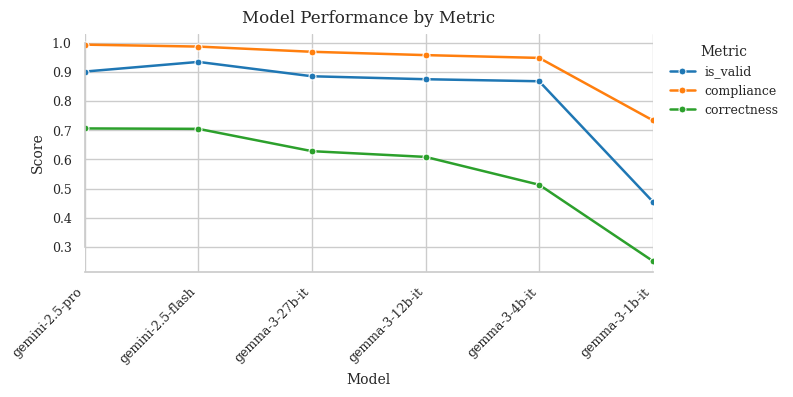

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Tighter context + smaller fonts
sns.set_theme(
    style="whitegrid",
    context="notebook",   # a bit bigger than "paper", but more compact overall
    font="serif",
    font_scale=1.0        # dial back the text size
)

df = t.T

# 2) Much shorter height, same width
fig, ax = plt.subplots(figsize=(8, 3.5))   # width 8", height 3.5"

palette = sns.color_palette("tab10", n_colors=len(df.columns))

# 3) Draw with no dashes, smaller markers
sns.lineplot(
    data=df,
    ax=ax,
    palette=palette,
    linewidth=1.8,
    marker="o",
    markersize=5,
    dashes=False,
)

# 4) Labels & ticks with minimal padding
ax.set_xlabel("Model", labelpad=5, fontsize=10)
ax.set_ylabel("Score", labelpad=5, fontsize=10)
ax.set_title("Model Performance by Metric", pad=8, fontsize=12)

ax.set_xticks(range(len(df.index)))
ax.set_xticklabels(df.index, rotation=45, ha="right", fontsize=9)
ax.tick_params(axis="y", labelsize=9)

# 5) Manual legend outside
ax.legend(
    title="Metric",
    loc="upper left",
    bbox_to_anchor=(1.01, 1.0),
    frameon=False,
    title_fontsize=10,
    fontsize=9
)

# 6) Kill extra margins & spine‐trim
ax.margins(x=0)                # hugs the x‐axis labels more tightly
sns.despine(trim=True)
plt.subplots_adjust(
    left=0.07,                  # more room on the left so y‐label isn't squished
    right=0.78,                 # carve out space for the legend
    top=0.88,
    bottom=0.2                  # lifts the x‐labels up so they don't overlap
)

plt.show()


## Prompt engineering

In [7]:
columns = ["gemini-2.5-flash", "gemini-2.5-flash_low", "gemma-3-12b-it",  "gemma-3-12b-it_low", "gemma-3-4b-it","gemma-3-4b-it_low"]
models = columns                                   

for metric, name in zip(["is_valid","compliance","correctness"], ["JSON Validity", "Format Compliance", "Content Correctness"]):
    df = pd.DataFrame(reshuffle[metric])[columns]
    display(
        pretty_table(
          df, 
          title=name  # e.g. "Is Valid"
        )
    )

,gemini-2.5-flash,gemini-2.5-flash_low,gemma-3-12b-it,gemma-3-12b-it_low,gemma-3-4b-it,gemma-3-4b-it_low
1-rotowire,0.90,1.00,0.90,0.90,0.90,0.90
2-wiki_bio,1.00,0.92,0.73,0.62,0.83,0.84
3-few_nerd,0.93,0.96,0.90,0.90,0.90,0.90
4-TOPv1,0.93,0.99,0.86,0.89,0.90,0.90
5-api_bank,0.99,1.00,1.00,0.96,0.86,0.82
6-reasoning/GSM8K,0.89,0.90,0.84,0.80,0.79,0.73
6-reasoning/last_letter,0.90,0.90,0.90,0.66,0.90,0.00


,gemini-2.5-flash,gemini-2.5-flash_low,gemma-3-12b-it,gemma-3-12b-it_low,gemma-3-4b-it,gemma-3-4b-it_low
1-rotowire,1.00,0.91,0.98,0.91,0.94,0.86
2-wiki_bio,0.97,0.84,0.97,0.85,0.96,0.85
3-few_nerd,1.00,1.00,0.99,1.00,1.00,1.00
4-TOPv1,0.95,0.94,0.77,0.83,0.77,0.79
5-api_bank,0.99,0.99,1.00,0.99,0.98,0.99
6-reasoning/GSM8K,1.00,0.68,1.00,0.89,0.97,0.94
6-reasoning/last_letter,1.00,1.00,1.00,1.00,1.00,1.00


,gemini-2.5-flash,gemini-2.5-flash_low,gemma-3-12b-it,gemma-3-12b-it_low,gemma-3-4b-it,gemma-3-4b-it_low
1-rotowire,0.54,0.50,0.54,0.54,0.49,0.45
2-wiki_bio,0.33,0.33,0.32,0.33,0.35,0.33
3-few_nerd,0.60,0.59,0.40,0.40,0.43,0.40
4-TOPv1,0.64,0.63,0.50,0.56,0.51,0.50
5-api_bank,0.92,0.91,0.81,0.78,0.80,0.81
6-reasoning/GSM8K,0.93,0.42,0.89,0.79,0.84,0.76
6-reasoning/last_letter,0.98,0.97,0.81,0.75,0.17,0.47


In [8]:
t = pd.DataFrame(agg_results(results, models=columns))
t

,gemini-2.5-flash,gemini-2.5-flash_low,gemma-3-12b-it,gemma-3-12b-it_low,gemma-3-4b-it,gemma-3-4b-it_low
is_valid,0.934714,0.953571,0.875286,0.818714,0.868286,0.728000
compliance,0.987286,0.909429,0.958000,0.923571,0.948429,0.918143
correctness,0.705000,0.621286,0.608714,0.593143,0.513143,0.531714


/var/folders/l6/h6gtp11j41nb58cqzlsr0yqh0000gp/T/ipykernel_77332/3185671921.py:28: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.lineplot(


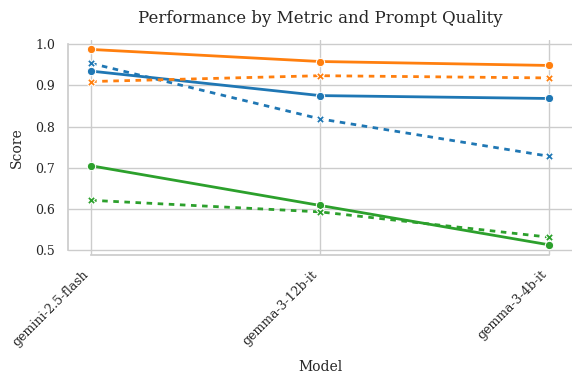

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ── 1) Build the DataFrame ────────────────────────────────────────────────
# (Assumes you already have `results` and `columns` defined)
t = pd.DataFrame(agg_results(results, models=columns))

# Melt it long so we can hue/style on different columns
df = (
    t.T
     .reset_index()
     .melt(id_vars="index", var_name="metric", value_name="score")
     .rename(columns={"index": "model"})
)

# Tag prompt‐quality and strip the suffix for plotting on x
df["prompt"] = np.where(df["model"].str.endswith("_low"), "low", "normal")
df["base_model"] = df["model"].str.replace(r"_low$", "", regex=True)


# ── 2) Create the plot ───────────────────────────────────────────────────
sns.set_theme(style="whitegrid", context="notebook", font="serif", font_scale=1)
palette = sns.color_palette("tab10", n_colors=len(df.columns))
fig, ax = plt.subplots(figsize=(6, 4))

sns.lineplot(
    data=df,
    x="base_model", 
    y="score",
    hue="metric",
    style="prompt",
    markers=True,
    dashes={"normal": "", "low": (2,2)},
    linewidth=2,
    markersize=6,
    ax=ax,
    legend="brief",       # prepare a combined legend for us
    palette=palette
)

# ── 3) Labels & ticks ────────────────────────────────────────────────────
ax.set_title("Performance by Metric and Prompt Quality", pad=12, fontsize=12)
ax.set_xlabel("Model", labelpad=8, fontsize=10)
ax.set_ylabel("Score", labelpad=8, fontsize=10)

base_models = df["base_model"].unique()
ax.set_xticks(range(len(base_models)))
ax.set_xticklabels(base_models, rotation=45, ha="right", fontsize=9)
ax.tick_params(axis="y", labelsize=9)
sns.despine(trim=True)


# ── 4) Split & restyle the legend ────────────────────────────────────────
# grab the handles/labels Seaborn made
handles, labels = ax.get_legend_handles_labels()

# separate them into metrics vs. prompts
metric_labels = ["is_valid", "compliance", "correctness"]
prompt_labels = ["normal", "low"]

metric_h = [h for h, l in zip(handles, labels) if l in metric_labels]
metric_l = [l for l in labels if l in metric_labels]

prompt_h = [h for h, l in zip(handles, labels) if l in prompt_labels]
prompt_l = [l for l in labels if l in prompt_labels]

# remove the combined box
ax.legend_.remove()
# ── 5) Finalize ───────────────────────────────────────────────────────────
plt.tight_layout()
plt.show()


### Remove reasoning tasks

/var/folders/l6/h6gtp11j41nb58cqzlsr0yqh0000gp/T/ipykernel_77332/3278082279.py:22: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.lineplot(


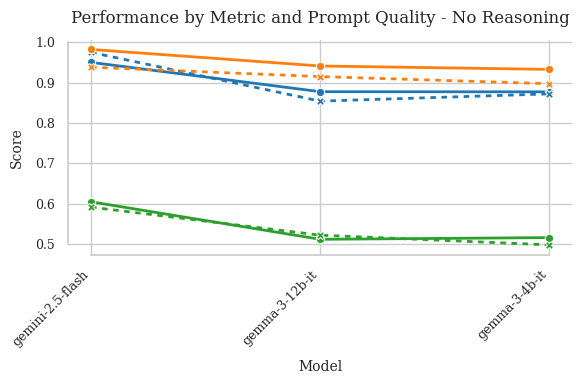

In [10]:
t = pd.DataFrame(agg_results(results, models=columns, tasks=[task for task in tasks if "reasoning" not in task ]))


# Melt it long so we can hue/style on different columns
df = (
    t.T
     .reset_index()
     .melt(id_vars="index", var_name="metric", value_name="score")
     .rename(columns={"index": "model"})
)

# Tag prompt‐quality and strip the suffix for plotting on x
df["prompt"] = np.where(df["model"].str.endswith("_low"), "low", "normal")
df["base_model"] = df["model"].str.replace(r"_low$", "", regex=True)


# ── 2) Create the plot ───────────────────────────────────────────────────
sns.set_theme(style="whitegrid", context="notebook", font="serif", font_scale=1)
palette = sns.color_palette("tab10", n_colors=len(df.columns))
fig, ax = plt.subplots(figsize=(6, 4))

sns.lineplot(
    data=df,
    x="base_model", 
    y="score",
    hue="metric",
    style="prompt",
    markers=True,
    dashes={"normal": "", "low": (2,2)},
    linewidth=2,
    markersize=6,
    ax=ax,
    legend="brief",       # prepare a combined legend for us
    palette=palette
)

# ── 3) Labels & ticks ────────────────────────────────────────────────────
ax.set_title("Performance by Metric and Prompt Quality - No Reasoning", pad=12, fontsize=12)
ax.set_xlabel("Model", labelpad=8, fontsize=10)
ax.set_ylabel("Score", labelpad=8, fontsize=10)

base_models = df["base_model"].unique()
ax.set_xticks(range(len(base_models)))
ax.set_xticklabels(base_models, rotation=45, ha="right", fontsize=9)
ax.tick_params(axis="y", labelsize=9)
sns.despine(trim=True)


# ── 4) Split & restyle the legend ────────────────────────────────────────
# grab the handles/labels Seaborn made
handles, labels = ax.get_legend_handles_labels()

# separate them into metrics vs. prompts
metric_labels = ["is_valid", "compliance", "correctness"]
prompt_labels = ["normal", "low"]

metric_h = [h for h, l in zip(handles, labels) if l in metric_labels]
metric_l = [l for l in labels if l in metric_labels]

prompt_h = [h for h, l in zip(handles, labels) if l in prompt_labels]
prompt_l = [l for l in labels if l in prompt_labels]

# remove the combined box
ax.legend_.remove()
# ── 5) Finalize ───────────────────────────────────────────────────────────
plt.tight_layout()
plt.show()


### legend

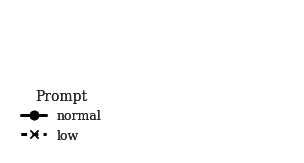

In [11]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ── 1)  Build proxy handles that match your plot styling ────────────────
# colours match seaborn "tab10" default that was used earlier
metric_handles = [
    Line2D([0], [0], color='tab:blue',   linewidth=2),   # is_valid
    Line2D([0], [0], color='tab:orange', linewidth=2),   # compliance
    Line2D([0], [0], color='tab:green',  linewidth=2)    # correctness
]
metric_labels = ['is_valid', 'compliance', 'correctness']

prompt_handles = [
    Line2D([0], [0], color='black', linewidth=2,
           marker='o', markersize=6, linestyle='-'),      # normal
    Line2D([0], [0], color='black', linewidth=2,
           marker='x', markersize=6, linestyle='--',
           dashes=(2, 2))                                 # low
]
prompt_labels = ['normal', 'low']

# ── 2)  Create a tiny figure that ONLY holds the legends ────────────────
fig_leg, ax_leg = plt.subplots(figsize=(3.2, 1.8))  # size to taste
ax_leg.axis('off')                                   # hide the axis frame

# # first legend (metrics) at the top
# leg1 = ax_leg.legend(metric_handles, metric_labels,
#                      title='Metric',
#                      loc='upper left',
#                      frameon=False,
#                      title_fontsize=10,
#                      fontsize=9)

# second legend (prompt quality) a bit lower
leg2 = ax_leg.legend(prompt_handles, prompt_labels,
                     title='Prompt',
                     loc='lower left',               # stacked below leg1
                     frameon=False,
                     title_fontsize=10,
                     fontsize=9)

# keep both legends
ax_leg.add_artist(leg2)

plt.tight_layout()
plt.show()


## Json mode

In [12]:
columns = [
    "gemini-2.5-flash",
    "gemini-2.5-flash_jsonmode",
    "gemini-2.5-flash_low",
    "gemini-2.5-flash_jsonmode_low",
]

for metric, name in zip(["is_valid","compliance","correctness"], ["JSON Validity", "Format Compliance", "Content Correctness"]):
    df = pd.DataFrame(reshuffle[metric])[columns]
    display(
        pretty_table(
          df, 
          title=name  # e.g. "Is Valid"
        )
    )

,gemini-2.5-flash,gemini-2.5-flash_jsonmode,gemini-2.5-flash_low,gemini-2.5-flash_jsonmode_low
1-rotowire,0.90,1.00,1.00,1.00
2-wiki_bio,1.00,1.00,0.92,1.00
3-few_nerd,0.93,1.00,0.96,1.00
4-TOPv1,0.93,1.00,0.99,1.00
5-api_bank,0.99,1.00,1.00,0.99
6-reasoning/GSM8K,0.89,1.00,0.90,1.00
6-reasoning/last_letter,0.90,1.00,0.90,1.00


,gemini-2.5-flash,gemini-2.5-flash_jsonmode,gemini-2.5-flash_low,gemini-2.5-flash_jsonmode_low
1-rotowire,1.00,1.00,0.91,0.93
2-wiki_bio,0.97,0.97,0.84,0.85
3-few_nerd,1.00,1.00,1.00,1.00
4-TOPv1,0.95,0.99,0.94,0.99
5-api_bank,0.99,1.00,0.99,0.99
6-reasoning/GSM8K,1.00,1.00,0.68,0.81
6-reasoning/last_letter,1.00,1.00,1.00,1.00


,gemini-2.5-flash,gemini-2.5-flash_jsonmode,gemini-2.5-flash_low,gemini-2.5-flash_jsonmode_low
1-rotowire,0.54,0.56,0.50,0.50
2-wiki_bio,0.33,0.33,0.33,0.33
3-few_nerd,0.60,0.58,0.59,0.59
4-TOPv1,0.64,0.65,0.63,0.63
5-api_bank,0.92,0.91,0.91,0.90
6-reasoning/GSM8K,0.93,0.92,0.42,0.59
6-reasoning/last_letter,0.98,0.97,0.97,0.97


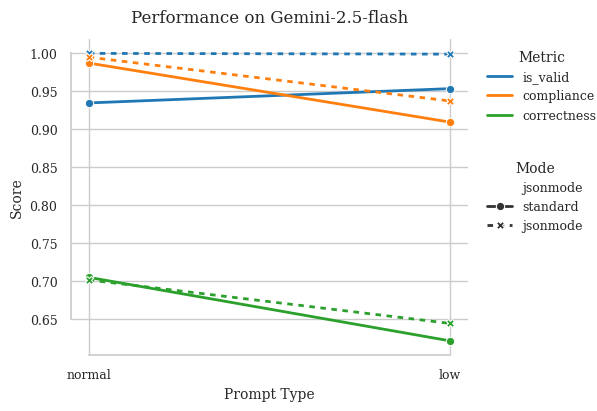

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ── 1) Prepare your DataFrame ─────────────────────────────────────────────

t = pd.DataFrame(agg_results(results, models=columns))

df = (
    t.T
     .reset_index()
     .melt(id_vars="index", var_name="metric", value_name="score")
     .rename(columns={"index": "model"})
)

# tag prompt type (x axis) and jsonmode (line style)
df["prompt"]   = np.where(df["model"].str.endswith("_low"), "low",    "normal")
df["jsonmode"] = np.where(df["model"].str.contains("jsonmode"), "jsonmode", "standard")

# ── 2) Plot ───────────────────────────────────────────────────────────────
sns.set_theme(style="whitegrid", context="notebook", font="serif", font_scale=1)
fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)

sns.lineplot(
    data=df,
    x="prompt",
    y="score",
    hue="metric",
    style="jsonmode",
    markers=True,
    dashes={"standard": "", "jsonmode": (2,2)},
    linewidth=2,
    markersize=6,
    ax=ax,
    legend="brief",
    palette="tab10"
)

# ── 3) Labels & ticks ─────────────────────────────────────────────────────
ax.set_title("Performance on Gemini-2.5-flash", pad=12, fontsize=12)
ax.set_xlabel("Prompt Type", fontsize=10)
ax.set_ylabel("Score", fontsize=10)

ax.set_xticks([0,1])
ax.set_xticklabels(["normal", "low"], rotation=0, fontsize=9)
ax.tick_params(axis="y", labelsize=9)
sns.despine(trim=True)

# ── 4) Split & clean up the legend ───────────────────────────────────────
handles, labels = ax.get_legend_handles_labels()

# separate metric vs style entries
metric_idx = [i for i,l in enumerate(labels) if l in ("is_valid","compliance","correctness")]
style_idx  = [i for i,l in enumerate(labels) if l in ("standard","jsonmode")]

metric_h = [handles[i] for i in metric_idx]
metric_l = [labels[i]  for i in metric_idx]
style_h  = [handles[i] for i in style_idx]
style_l  = [labels[i]  for i in style_idx]

ax.legend_.remove()

# Metrics legend
leg1 = ax.legend(
    metric_h, metric_l,
    title="Metric",
    loc="upper left",
    bbox_to_anchor=(1.02, 1.00),
    frameon=False,
    title_fontsize=10,
    fontsize=9
)
ax.add_artist(leg1)

# JSON-mode vs standard legend
leg2 = ax.legend(
    style_h, style_l,
    title="Mode",
    loc="upper left",
    bbox_to_anchor=(1.02, 0.65),
    frameon=False,
    title_fontsize=10,
    fontsize=9
)

plt.show()


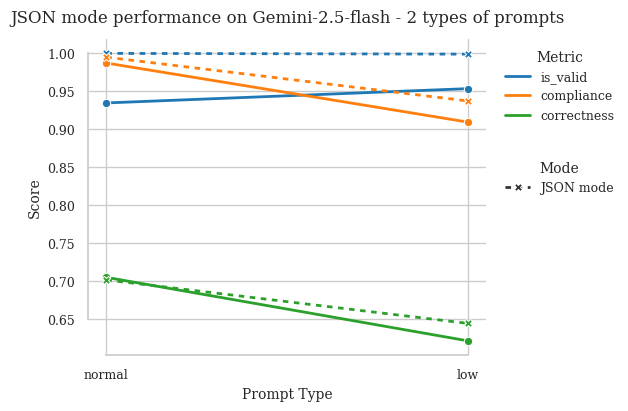

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ── 1) Prepare your DataFrame ─────────────────────────────────────────────
columns = [
    "gemini-2.5-flash",
    "gemini-2.5-flash_jsonmode",
    "gemini-2.5-flash_low",
    "gemini-2.5-flash_jsonmode_low",
]
t = pd.DataFrame(agg_results(results, models=columns))

df = (
    t.T
     .reset_index()
     .melt(id_vars="index", var_name="metric", value_name="score")
     .rename(columns={"index": "model"})
)

# tag prompt type (x axis) and jsonmode (line style)
df["prompt"]   = np.where(df["model"].str.endswith("_low"), "low",    "normal")
df["jsonmode"] = np.where(df["model"].str.contains("jsonmode"), "jsonmode", "standard")

# ── 2) Plot ───────────────────────────────────────────────────────────────
sns.set_theme(style="whitegrid", context="notebook", font="serif", font_scale=1)
fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)

sns.lineplot(
    data=df,
    x="prompt",
    y="score",
    hue="metric",
    style="jsonmode",
    markers=True,
    dashes={"standard": "", "jsonmode": (2,2)},
    linewidth=2,
    markersize=6,
    ax=ax,
    legend="brief",
    palette="tab10"
)

# ── 3) Labels & ticks ─────────────────────────────────────────────────────
ax.set_title("JSON mode performance on Gemini-2.5-flash - 2 types of prompts", pad=12, fontsize=12)
ax.set_xlabel("Prompt Type", fontsize=10)
ax.set_ylabel("Score", fontsize=10)

ax.set_xticks([0,1])
ax.set_xticklabels(["normal", "low"], rotation=0, fontsize=9)
ax.tick_params(axis="y", labelsize=9)
sns.despine(trim=True)

# ── 4) Split & clean up the legend ───────────────────────────────────────
handles, labels = ax.get_legend_handles_labels()

# separate metric vs style entries
metric_idx = [i for i,l in enumerate(labels) if l in ("is_valid","compliance","correctness")]
style_idx  = [i for i,l in enumerate(labels) if l in ("standard","jsonmode")]

metric_h = [handles[i] for i in metric_idx]
metric_l = [labels[i]  for i in metric_idx]
style_h  = [handles[i] for i in style_idx]
style_l  = [labels[i]  for i in style_idx]

ax.legend_.remove()

# Metrics legend
leg1 = ax.legend(
    metric_h, metric_l,
    title="Metric",
    loc="upper left",
    bbox_to_anchor=(1.02, 1.00),
    frameon=False,
    title_fontsize=10,
    fontsize=9
)
ax.add_artist(leg1)

# JSON-mode vs standard legend
# ── only show the JSON-mode line, and label it nicely ────────────────────
json_handle = prompt_h[1]    # the dashed “jsonmode” line
leg2 = ax.legend(
    [json_handle],
    ["JSON mode"],            # cleaner label
    title="Mode",
    loc="upper left",
    bbox_to_anchor=(1.02, 0.65),
    frameon=False,
    title_fontsize=10,
    fontsize=9
)
plt.show()


## Speed

In [15]:
time_results = pd.read_json("results/bench_results_time.json")
del time_results["gemma-3-4b-it_transformers_reasoning_free"]
t = pd.DataFrame(time_results).iloc[0:-2].round(2)

t.loc["overall"].sort_values(ascending=True)


gemma-3-1b-it_vllm                       589.15
gemma-3-4b-it_vllm                       699.70
gemma-3-4b-it_transformers              3039.96
gemma-3-1b-it_vllm_outlines             4388.85
gemma-3-4b-it_vllm_outlines             4660.70
gemma-3-12b-it_vllm                     5676.10
gemma-3-4b-it_transformers_guidance     8894.15
gemma-3-4b-it_transformers_outlines     9654.00
gemma-3-12b-it_vllm_outlines           21858.83
Name: overall, dtype: float64

In [16]:
col_order = t.loc["overall"].sort_values().index
t_ordered = t[col_order]

# 3) Simple styling: no background, integers only
styled = (
    t_ordered.style
              .format("{:.0f}")        # drop all decimals
              .set_table_styles([
              # header cells
              {
                  "selector": "th",
                  "props": [
                      ("background-color", "white"),
                      ("color", "black"),
                      ("font-weight", "bold"),
                      ("padding", "6px"),
                      ("border", "1px solid #ddd")
                  ]
              }])
)

# 4) Display it
display(styled)

,gemma-3-1b-it_vllm,gemma-3-4b-it_vllm,gemma-3-4b-it_transformers,gemma-3-1b-it_vllm_outlines,gemma-3-4b-it_vllm_outlines,gemma-3-12b-it_vllm,gemma-3-4b-it_transformers_guidance,gemma-3-4b-it_transformers_outlines,gemma-3-12b-it_vllm_outlines
1-rotowire,76,272,1101,1256,1287,907,3713,1171,5675
2-wiki_bio,80,46,180,1073,1151,902,1205,1715,5496
3-few_nerd,85,13,51,1143,727,876,400,576,6777
4-TOPv1,155,163,868,97,192,1290,1663,1042,373
5-api_bank,143,76,447,332,738,1312,512,4243,131
6-reasoning/GSM8K,26,61,192,319,353,195,1051,713,1650
6-reasoning/last_letter,26,69,201,168,213,194,349,195,1757
overall,589,700,3040,4389,4661,5676,8894,9654,21859


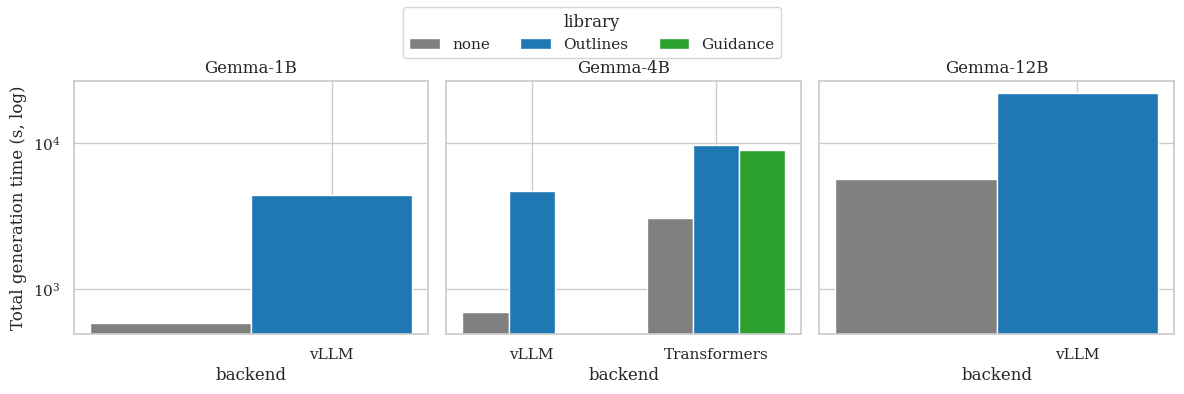

In [17]:
import pandas as pd, matplotlib.pyplot as plt
import numpy as np

# ---------------- raw numbers -----------------
df = pd.DataFrame({
    "model":  ["gemma-1B",  "gemma-1B",
               "gemma-4B",  "gemma-4B",  "gemma-4B",
               "gemma-4B",  "gemma-4B",
               "gemma-12B", "gemma-12B"],
    "backend":["vLLM",      "vLLM",
               "vLLM",      "vLLM",      "Transformers",
               "Transformers","Transformers",
               "vLLM",      "vLLM"],
    "library":["none",      "Outlines",
               "none",      "Outlines",  "none",
               "Outlines",  "Guidance",
               "none",      "Outlines"],
    "seconds":[589.15,      4388.85,
               699.70,      4660.70,     3039.96,
               9654.00,     8894.15,
               5676.10,     21858.83]
})

models_order  = ["gemma-1B", "gemma-4B", "gemma-12B"]
libs_order    = ["none", "Outlines", "Guidance"]
palette       = {"none": "#808080",   # grey
                 "Outlines": "#1f77b4",   # blue
                 "Guidance": "#2ca02c"}   # green

bar_width = 0.25                    # identical width everywhere
fig, axes = plt.subplots(1, len(models_order), figsize=(12, 4), sharey=True)

for ax, mdl in zip(axes, models_order):
    sub = df[df["model"] == mdl]
    # keep a stable x-offset for each backend
    backends = sub["backend"].unique()
    x = np.arange(len(backends))
    for j, lib in enumerate(libs_order):
        # fetch seconds or NaN if that (backend, lib) combo is missing
        y = [sub[(sub.backend == b) & (sub.library == lib)]["seconds"].values
             for b in backends]
        y = [v[0] if len(v) else np.nan for v in y]
        ax.bar(x + j*bar_width,
               y,
               width=bar_width,
               color=palette[lib],
               label=lib if mdl == models_order[0] else "",  # one legend entry
               log=True)

    ax.set_xticks(x + bar_width)     # centre tick under group
    ax.set_xticklabels(backends)
    ax.set_title(mdl.title())
    ax.set_xlabel("backend")

axes[0].set_ylabel("Total generation time (s, log)")
fig.legend(title="library", loc="upper center", ncol=3)
fig.tight_layout(rect=[0, 0, 1, 0.9])   # leave room for shared legend


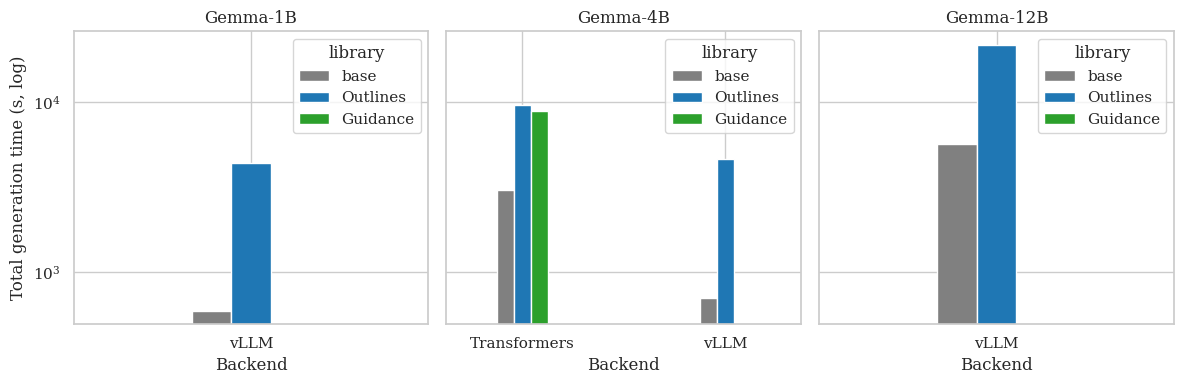

In [18]:
import pandas as pd, matplotlib.pyplot as plt

# ----------------------------- data ------------------------------------------
df = pd.DataFrame({
    "model":  ["gemma-1B",  "gemma-1B",
               "gemma-4B",  "gemma-4B",  "gemma-4B",
               "gemma-4B",  "gemma-4B",
               "gemma-12B", "gemma-12B"],
    "backend":["vLLM",      "vLLM",
               "vLLM",      "vLLM",      "Transformers",
               "Transformers","Transformers",
               "vLLM",      "vLLM"],
    "library":["base",      "Outlines",
               "base",      "Outlines",  "base",
               "Outlines",  "Guidance",
               "base",      "Outlines"],
    "seconds":[589.15,      4388.85,
               699.70,      4660.70,     3039.96,
               9654.00,     8894.15,
               5676.10,     21858.83]
})

# --------------------------- style helpers -----------------------------------
palette = {"base": "#808080",        # grey
           "Outlines": "#1f77b4",    # blue
           "Guidance": "#2ca02c"}    # green

models_order = ["gemma-1B", "gemma-4B", "gemma-12B"]
libs_order   = ["base", "Outlines", "Guidance"]        # fixed column order

# ----------------------------- plot ------------------------------------------
fig, axes = plt.subplots(1, len(models_order), figsize=(12, 4), sharey=True)

for ax, mdl in zip(axes, models_order):
    sub = df[df["model"] == mdl]
    sub_piv = sub.pivot(index="backend", columns="library", values="seconds") \
                 .reindex(columns=libs_order)           # ensure 3 columns everywhere

    sub_piv.plot(kind="bar",
                 ax=ax,
                 logy=True,
                 width=0.25,                            # constant bar width
                 color=[palette[c] for c in sub_piv.columns],
                 rot=0)

    ax.set_title(mdl.title())             # concise titles
    ax.set_xlabel("Backend")

axes[0].set_ylabel("Total generation time (s, log)")
fig.tight_layout()


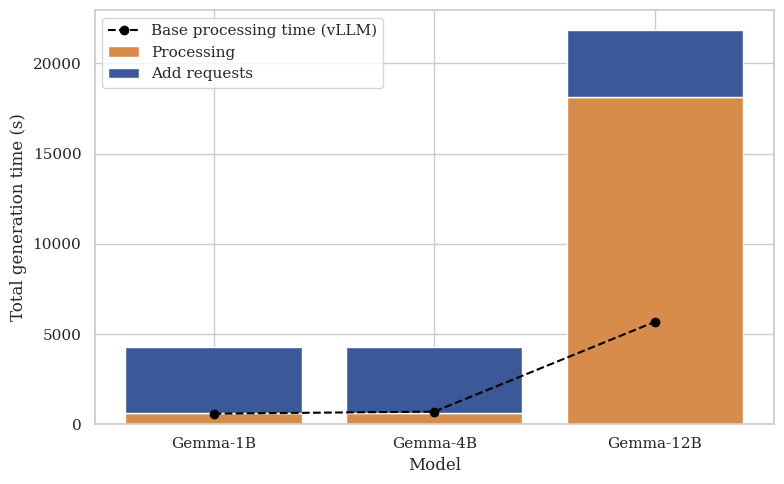

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------------------------------------------- data -------
vllm_outlines_results = {
    "gemma-1B":  {"outlines": {"Add requests": 3643, "Processing": 647},  "base":  589},
    "gemma-4B":  {"outlines": {"Add requests": 3610, "Processing": 650},  "base":  700},
    "gemma-12B": {"outlines": {"Add requests": 3712, "Processing": 18146}, "base": 5676},
}

models      = ["gemma-1B", "gemma-4B", "gemma-12B"]
proc_times  = [vllm_outlines_results[m]["outlines"]["Processing"]   for m in models]
add_times   = [vllm_outlines_results[m]["outlines"]["Add requests"] for m in models]
base_times  = [vllm_outlines_results[m]["base"]                     for m in models]

# ---------------------------------------------------------------- plot -------
fig, ax = plt.subplots(figsize=(8, 5))

x = np.arange(len(models))

# *** Processing at the bottom ***
bars_proc = ax.bar(x, proc_times, label="Processing", color="#d88c4b")       # muted orange
# *** Add requests stacked on top ***
bars_add  = ax.bar(x, add_times, bottom=proc_times, label="Add requests", color="#3b5998")  # blue

# *** Baseline line, distinct colour & style ***
ax.plot(x, base_times, marker="o", linestyle="--", color="black", label="Base processing time (vLLM)")

# Axis & legend
ax.set_xticks(x)
ax.set_xticklabels([m.title() for m in models])
ax.set_ylabel("Total generation time (s)")
ax.set_xlabel("Model")
ax.legend()

fig.tight_layout()


## Overall results

In [20]:
columns = [
    m
    for m in results.keys()
    if not any(substr in m for substr in ("free", "jsonmode", "_low", "gemini", "27b"))
]
## reorder
size_order = {'1b': 0, '4b': 1, '12b': 2}
backend_order = {
    '': 0,
    'vllm': 1,
    'vllm_outlines': 2,
    'transformers': 3,
    'transformers_outlines': 4,
    'transformers_guidance': 5,
}

import re

def sort_key(model):
    m = re.match(r'gemma-3-(?P<size>\d+b)-it(?:_(?P<backend>.*))?', model)
    size = m.group('size')
    backend = m.group('backend') or ''
    return (size_order[size], backend_order.get(backend, 99), model)

sorted_models = sorted(columns, key=sort_key)
sorted_models

['gemma-3-1b-it',
 'gemma-3-1b-it_vllm',
 'gemma-3-1b-it_vllm_outlines',
 'gemma-3-4b-it',
 'gemma-3-4b-it_vllm',
 'gemma-3-4b-it_vllm_outlines',
 'gemma-3-4b-it_transformers',
 'gemma-3-4b-it_transformers_outlines',
 'gemma-3-4b-it_transformers_guidance',
 'gemma-3-12b-it',
 'gemma-3-12b-it_vllm',
 'gemma-3-12b-it_vllm_outlines']

In [21]:
for metric, name in zip(["is_valid","compliance","correctness"], ["JSON Validity", "Format Compliance", "Content Correctness"]):
    df = pd.DataFrame(reshuffle[metric])[sorted_models]
    display(
        pretty_table(
          df, 
          title=name  # e.g. "Is Valid"
        ))

,gemma-3-1b-it,gemma-3-1b-it_vllm,gemma-3-1b-it_vllm_outlines,gemma-3-4b-it,gemma-3-4b-it_vllm,gemma-3-4b-it_vllm_outlines,gemma-3-4b-it_transformers,gemma-3-4b-it_transformers_outlines,gemma-3-4b-it_transformers_guidance,gemma-3-12b-it,gemma-3-12b-it_vllm,gemma-3-12b-it_vllm_outlines
1-rotowire,0.81,0.00,0.95,0.90,0.81,0.02,0.05,1.00,0.70,0.90,0.00,0.25
2-wiki_bio,0.50,0.00,0.98,0.83,0.89,0.96,0.05,1.00,1.00,0.73,0.01,0.29
3-few_nerd,0.00,0.00,0.89,0.90,0.77,0.78,0.06,0.07,1.00,0.90,0.00,0.01
4-TOPv1,0.01,0.00,1.00,0.90,0.00,1.00,0.00,0.57,0.98,0.86,0.00,0.99
5-api_bank,0.19,0.26,0.97,0.86,0.42,0.94,0.04,1.00,1.00,1.00,0.00,1.00
6-reasoning/GSM8K,0.69,0.16,0.92,0.79,0.74,0.98,0.02,0.94,0.95,0.84,0.00,0.00
6-reasoning/last_letter,0.98,0.00,1.00,0.90,0.00,1.00,0.00,1.00,1.00,0.90,0.00,0.00


,gemma-3-1b-it,gemma-3-1b-it_vllm,gemma-3-1b-it_vllm_outlines,gemma-3-4b-it,gemma-3-4b-it_vllm,gemma-3-4b-it_vllm_outlines,gemma-3-4b-it_transformers,gemma-3-4b-it_transformers_outlines,gemma-3-4b-it_transformers_guidance,gemma-3-12b-it,gemma-3-12b-it_vllm,gemma-3-12b-it_vllm_outlines
1-rotowire,0.88,0.84,0.76,0.94,0.89,0.01,0.61,0.89,0.03,0.98,0.00,0.00
2-wiki_bio,0.82,0.68,0.99,0.96,0.96,1.00,0.42,1.00,1.00,0.97,0.01,0.36
3-few_nerd,0.75,0.63,0.00,1.00,1.00,0.00,0.92,0.92,1.00,0.99,0.00,0.00
4-TOPv1,0.62,0.01,0.00,0.77,0.33,0.00,0.36,0.33,0.00,0.77,0.00,0.00
5-api_bank,0.21,0.07,0.00,0.98,0.87,0.00,0.09,0.75,0.66,1.00,0.00,0.00
6-reasoning/GSM8K,0.86,0.38,0.95,0.97,0.91,0.99,0.85,0.96,0.97,1.00,0.03,0.51
6-reasoning/last_letter,1.00,0.49,1.00,1.00,0.47,1.00,0.49,1.00,1.00,1.00,0.01,0.50


,gemma-3-1b-it,gemma-3-1b-it_vllm,gemma-3-1b-it_vllm_outlines,gemma-3-4b-it,gemma-3-4b-it_vllm,gemma-3-4b-it_vllm_outlines,gemma-3-4b-it_transformers,gemma-3-4b-it_transformers_outlines,gemma-3-4b-it_transformers_guidance,gemma-3-12b-it,gemma-3-12b-it_vllm,gemma-3-12b-it_vllm_outlines
1-rotowire,0.40,0.23,0.20,0.49,0.45,0.00,0.30,0.47,0.01,0.54,0.00,0.00
2-wiki_bio,0.24,0.21,0.27,0.35,0.35,0.28,0.16,0.35,0.35,0.32,0.00,0.00
3-few_nerd,0.23,0.16,0.00,0.43,0.43,0.01,0.40,0.35,0.42,0.40,0.00,0.00
4-TOPv1,0.25,0.00,0.00,0.51,0.21,0.00,0.22,0.21,0.12,0.50,0.00,0.00
5-api_bank,0.32,0.12,0.00,0.80,0.69,0.00,0.08,0.64,0.63,0.81,0.00,0.00
6-reasoning/GSM8K,0.32,0.04,0.09,0.84,0.74,0.41,0.67,0.78,0.80,0.89,0.00,0.00
6-reasoning/last_letter,0.00,0.00,0.00,0.17,0.02,0.12,0.01,0.38,0.47,0.81,0.00,0.00


In [22]:
for metric, name in zip(["is_valid","compliance","correctness"], ["JSON Validity", "Format Compliance", "Content Correctness"]):
    df = pd.DataFrame(reshuffle[metric]).loc[:, [model for model in sorted_models if "12b" in model]]
    display(
        pretty_table(
          df, 
          title=name  # e.g. "Is Valid"
        ))

,gemma-3-12b-it,gemma-3-12b-it_vllm,gemma-3-12b-it_vllm_outlines
1-rotowire,0.90,0.00,0.25
2-wiki_bio,0.73,0.01,0.29
3-few_nerd,0.90,0.00,0.01
4-TOPv1,0.86,0.00,0.99
5-api_bank,1.00,0.00,1.00
6-reasoning/GSM8K,0.84,0.00,0.00
6-reasoning/last_letter,0.90,0.00,0.00


,gemma-3-12b-it,gemma-3-12b-it_vllm,gemma-3-12b-it_vllm_outlines
1-rotowire,0.98,0.00,0.00
2-wiki_bio,0.97,0.01,0.36
3-few_nerd,0.99,0.00,0.00
4-TOPv1,0.77,0.00,0.00
5-api_bank,1.00,0.00,0.00
6-reasoning/GSM8K,1.00,0.03,0.51
6-reasoning/last_letter,1.00,0.01,0.50


,gemma-3-12b-it,gemma-3-12b-it_vllm,gemma-3-12b-it_vllm_outlines
1-rotowire,0.54,0.00,0.00
2-wiki_bio,0.32,0.00,0.00
3-few_nerd,0.40,0.00,0.00
4-TOPv1,0.50,0.00,0.00
5-api_bank,0.81,0.00,0.00
6-reasoning/GSM8K,0.89,0.00,0.00
6-reasoning/last_letter,0.81,0.00,0.00


### 4B - transformers

In [23]:
models_4B = [model for model in sorted_models if "4b" in model and "vllm" not in model]

for metric, name in zip(["is_valid","compliance","correctness"], ["JSON Validity", "Format Compliance", "Content Correctness"]):
    df = pd.DataFrame(reshuffle[metric])[models_4B]
    display(
        pretty_table(
          df, 
          title=name  # e.g. "Is Valid"
        ))

,gemma-3-4b-it,gemma-3-4b-it_transformers,gemma-3-4b-it_transformers_outlines,gemma-3-4b-it_transformers_guidance
1-rotowire,0.90,0.05,1.00,0.70
2-wiki_bio,0.83,0.05,1.00,1.00
3-few_nerd,0.90,0.06,0.07,1.00
4-TOPv1,0.90,0.00,0.57,0.98
5-api_bank,0.86,0.04,1.00,1.00
6-reasoning/GSM8K,0.79,0.02,0.94,0.95
6-reasoning/last_letter,0.90,0.00,1.00,1.00


,gemma-3-4b-it,gemma-3-4b-it_transformers,gemma-3-4b-it_transformers_outlines,gemma-3-4b-it_transformers_guidance
1-rotowire,0.94,0.61,0.89,0.03
2-wiki_bio,0.96,0.42,1.00,1.00
3-few_nerd,1.00,0.92,0.92,1.00
4-TOPv1,0.77,0.36,0.33,0.00
5-api_bank,0.98,0.09,0.75,0.66
6-reasoning/GSM8K,0.97,0.85,0.96,0.97
6-reasoning/last_letter,1.00,0.49,1.00,1.00


,gemma-3-4b-it,gemma-3-4b-it_transformers,gemma-3-4b-it_transformers_outlines,gemma-3-4b-it_transformers_guidance
1-rotowire,0.49,0.30,0.47,0.01
2-wiki_bio,0.35,0.16,0.35,0.35
3-few_nerd,0.43,0.40,0.35,0.42
4-TOPv1,0.51,0.22,0.21,0.12
5-api_bank,0.80,0.08,0.64,0.63
6-reasoning/GSM8K,0.84,0.67,0.78,0.80
6-reasoning/last_letter,0.17,0.01,0.38,0.47


In [24]:
df = pd.DataFrame(agg_results(results, models=models_4B))
display(
        pretty_table(
          df, 
          title=name  # e.g. "Is Valid"
        ))
df = df.T


,gemma-3-4b-it,gemma-3-4b-it_transformers,gemma-3-4b-it_transformers_outlines,gemma-3-4b-it_transformers_guidance
is_valid,0.87,0.03,0.80,0.95
compliance,0.95,0.54,0.83,0.67
correctness,0.51,0.26,0.45,0.40


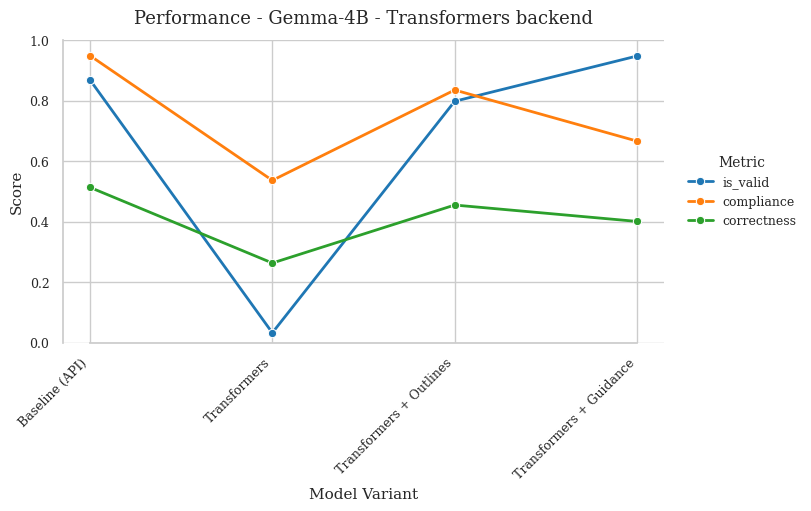

In [25]:
label_map = {
    "gemma-3-4b-it":                         "Baseline (API)",
    "gemma-3-4b-it_transformers":            "Transformers",
    "gemma-3-4b-it_transformers_outlines":   "Transformers + Outlines",
    "gemma-3-4b-it_transformers_guidance":   "Transformers + Guidance",
}

df = df.rename(index=label_map)

# ── 2) Plot with solid lines only ─────────────────────────────────────────
sns.set_theme(style="whitegrid", context="notebook", font="serif", font_scale=1)
fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)

sns.lineplot(
    data=df,
    marker="o",
    markersize=6,
    linewidth=2,
    dashes=False,              # force all lines solid
    palette=["tab:blue","tab:orange","tab:green"],
    ax=ax
)

# ── 3) Axis labels, grid, ticks ──────────────────────────────────────────
ax.set_title("Performance - Gemma-4B - Transformers backend", pad=12, fontsize=13)
ax.set_xlabel("Model Variant", fontsize=11)
ax.set_ylabel("Score", fontsize=11)
ax.set_ylim(0, 1)

ax.set_xticks(range(len(df.index)))
ax.set_xticklabels(df.index, rotation=45, ha="right", fontsize=9)
ax.tick_params(axis="y", labelsize=9)
sns.despine(ax=ax, trim=True)

# ── 4) Clean legend ──────────────────────────────────────────────────────
handles, labels = ax.get_legend_handles_labels()
# ensure order is exactly is_valid, compliance, correctness
order = ["is_valid","compliance","correctness"]
handles = [handles[labels.index(m)] for m in order]
labels  = order

ax.legend(
    handles,
    labels,
    title="Metric",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
    title_fontsize=10,
    fontsize=9
)

plt.show()

### 1B4B

In [26]:
models_1B4B = ["gemma-3-1b-it",	"gemma-3-1b-it_vllm", "gemma-3-1b-it_vllm_outlines", "gemma-3-4b-it",	"gemma-3-4b-it_vllm", "gemma-3-4b-it_vllm_outlines"]

for metric, name in zip(["is_valid","compliance","correctness"], ["JSON Validity", "Format Compliance", "Content Correctness"]):
    df = pd.DataFrame(reshuffle[metric])[models_1B4B]
    display(
        pretty_table(
          df, 
          title=name  # e.g. "Is Valid"
        ))

,gemma-3-1b-it,gemma-3-1b-it_vllm,gemma-3-1b-it_vllm_outlines,gemma-3-4b-it,gemma-3-4b-it_vllm,gemma-3-4b-it_vllm_outlines
1-rotowire,0.81,0.00,0.95,0.90,0.81,0.02
2-wiki_bio,0.50,0.00,0.98,0.83,0.89,0.96
3-few_nerd,0.00,0.00,0.89,0.90,0.77,0.78
4-TOPv1,0.01,0.00,1.00,0.90,0.00,1.00
5-api_bank,0.19,0.26,0.97,0.86,0.42,0.94
6-reasoning/GSM8K,0.69,0.16,0.92,0.79,0.74,0.98
6-reasoning/last_letter,0.98,0.00,1.00,0.90,0.00,1.00


,gemma-3-1b-it,gemma-3-1b-it_vllm,gemma-3-1b-it_vllm_outlines,gemma-3-4b-it,gemma-3-4b-it_vllm,gemma-3-4b-it_vllm_outlines
1-rotowire,0.88,0.84,0.76,0.94,0.89,0.01
2-wiki_bio,0.82,0.68,0.99,0.96,0.96,1.00
3-few_nerd,0.75,0.63,0.00,1.00,1.00,0.00
4-TOPv1,0.62,0.01,0.00,0.77,0.33,0.00
5-api_bank,0.21,0.07,0.00,0.98,0.87,0.00
6-reasoning/GSM8K,0.86,0.38,0.95,0.97,0.91,0.99
6-reasoning/last_letter,1.00,0.49,1.00,1.00,0.47,1.00


,gemma-3-1b-it,gemma-3-1b-it_vllm,gemma-3-1b-it_vllm_outlines,gemma-3-4b-it,gemma-3-4b-it_vllm,gemma-3-4b-it_vllm_outlines
1-rotowire,0.40,0.23,0.20,0.49,0.45,0.00
2-wiki_bio,0.24,0.21,0.27,0.35,0.35,0.28
3-few_nerd,0.23,0.16,0.00,0.43,0.43,0.01
4-TOPv1,0.25,0.00,0.00,0.51,0.21,0.00
5-api_bank,0.32,0.12,0.00,0.80,0.69,0.00
6-reasoning/GSM8K,0.32,0.04,0.09,0.84,0.74,0.41
6-reasoning/last_letter,0.00,0.00,0.00,0.17,0.02,0.12


In [27]:
t = pd.DataFrame(agg_results(results, models=models_1B4B))
display(
        pretty_table(
          t, 
          title=name  # e.g. "Is Valid"
        ))

,gemma-3-1b-it,gemma-3-1b-it_vllm,gemma-3-1b-it_vllm_outlines,gemma-3-4b-it,gemma-3-4b-it_vllm,gemma-3-4b-it_vllm_outlines
is_valid,0.46,0.06,0.96,0.87,0.52,0.81
compliance,0.73,0.44,0.53,0.95,0.78,0.43
correctness,0.25,0.11,0.08,0.51,0.41,0.12


In [28]:
from matplotlib.ticker import MultipleLocator

def plot_variants(variants, title):
    # long-form
    df = (
        t[variants].T.reset_index()
          .melt(id_vars="index", var_name="metric", value_name="score")
          .rename(columns={"index":"variant"})
    )
    df["category"] = df["variant"].map({
        variants[0]: "normal",
        variants[1]: "vLLM",
        variants[2]: "vLLM + Outlines"
    })

    sns.set_theme(style="whitegrid", context="notebook", font="serif", font_scale=1)
    fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)

    sns.lineplot(
        data=df,
        x="category", y="score",
        hue="metric",
        marker="o", linewidth=2, markersize=6,
        palette=["tab:blue","tab:orange","tab:green"],
        ax=ax
    )

    ax.set_title(f"Performance on {title}", pad=12, fontsize=12)
    ax.set_xlabel("")  
    ax.set_ylabel("Score", fontsize=10)

    # ○── Extend the y-axis to 0.0 and force uniform 0.1 steps
    ax.set_ylim(0.0, 1.0)
    ax.yaxis.set_major_locator(MultipleLocator(0.1))

    # ○── Don’t trim the bottom spine away so its grid-line shows
    sns.despine(ax=ax, trim=False, left=True)

    # ○── X ticks
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(["normal","vLLM","vLLM + Outlines"],
                       rotation=45, ha="right", fontsize=9)
    ax.tick_params(axis="y", labelsize=9)

    # ○── Legend
    ax.legend(
        title="Metric",
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        frameon=False,
        title_fontsize=10,
        fontsize=9
    )

    plt.show()

plot_variants(variants_1b, "Gemma-3-1b-it")
plot_variants(variants_4b, "Gemma-3-4b-it")

NameError: name 'variants_1b' is not defined

## Reasoning focus

In [66]:
columns = [
    m
    for m in results.keys()
    if "4b" in m and "transformers" in m and 'low' not in m
]
## reorder
size_order = {'1b': 0, '4b': 1, '12b': 2}
backend_order = {
    '': 0,
    'vllm': 1,
    'vllm_outlines': 2,
    'transformers': 3,
    'transformers_outlines': 4,
    'transformers_guidance': 5,
}

def sort_key(model):
    m = re.match(r'gemma-3-(?P<size>\d+b)-it(?:_(?P<backend>.*))?', model)
    size = m.group('size')
    backend = m.group('backend') or ''
    return (size_order[size], backend_order.get(backend, 99), model)

sorted_models = sorted(columns, key=sort_key)

metric, name = ("correctness", "Content Correctness")
df = pd.DataFrame(reshuffle[metric])[sorted_models].loc[["6-reasoning/GSM8K", "6-reasoning/last_letter"]]
df.rename(columns={"gemma-3-4b-it_transformers_reasoning_free": "Free Generation",
                   "gemma-3-4b-it_transformers": "Free Structured",
                   "gemma-3-4b-it_transformers_outlines": "Outlines",
                   "gemma-3-4b-it_transformers_guidance": "Guidance",
                   }, inplace=True)
df = df.loc[:, ["Free Generation", "Free Structured", "Outlines", "Guidance"]]
display(
    pretty_table(
      df, 
      title=name  # e.g. "Is Valid"
    ))

,Free Generation,Free Structured,Outlines,Guidance
6-reasoning/GSM8K,0.72,0.67,0.78,0.80
6-reasoning/last_letter,0.41,0.01,0.38,0.47


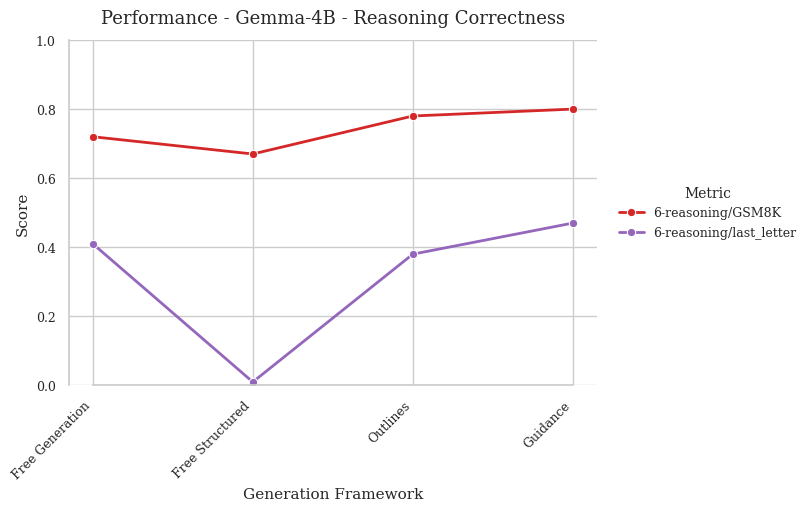

In [67]:
df = df.T
fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)

sns.lineplot(
    data=df,
    marker="o",
    markersize=6,
    linewidth=2,
    dashes=False,              # force all lines solid
    palette=["tab:red","tab:purple"],
    ax=ax
)

# ── 3) Axis labels, grid, ticks ──────────────────────────────────────────
ax.set_title("Performance - Gemma-4B - Reasoning Correctness", pad=12, fontsize=13)
ax.set_xlabel("Generation Framework", fontsize=11)
ax.set_ylabel("Score", fontsize=11)
ax.set_ylim(0, 1)

ax.set_xticks(range(len(df.index)))
ax.set_xticklabels(df.index, rotation=45, ha="right", fontsize=9)
ax.tick_params(axis="y", labelsize=9)
sns.despine(ax=ax, trim=True)

# ── 4) Clean legend ──────────────────────────────────────────────────────
handles, labels = ax.get_legend_handles_labels()
# ensure order is exactly is_valid, compliance, correctness

ax.legend(
    handles,
    labels,
    title="Metric",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
    title_fontsize=10,
    fontsize=9
)

plt.show()

/var/folders/l6/h6gtp11j41nb58cqzlsr0yqh0000gp/T/ipykernel_77332/1269256298.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.index, rotation=45, ha="right", fontsize=9)


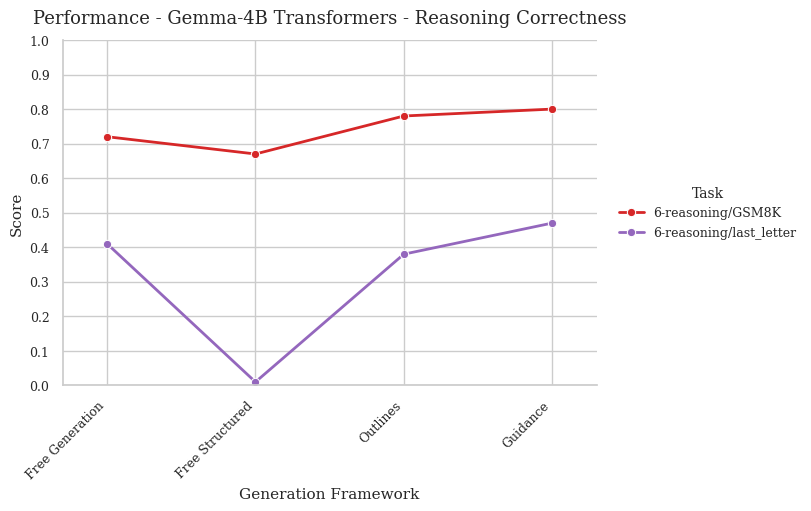

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# 2) Plot all‐solid, no sorting:
sns.set_theme(style="whitegrid", context="notebook", font="serif", font_scale=1)
fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)

sns.lineplot(
    data=df,
    marker="o",
    markersize=6,
    linewidth=2,
    dashes=False,       # all lines solid
    palette=["tab:red","tab:purple"],
    ax=ax,
    sort=False          # VERY IMPORTANT: preserves the order you gave above
)

# 3) Add horizontal padding so the end‐points aren’t jammed up
ax.margins(x=0.1)

# 4) Force a nice 0.0–1.0 grid in steps of 0.1
ax.set_ylim(0,1)
ax.yaxis.set_major_locator(MultipleLocator(0.1))
sns.despine(ax=ax, trim=False)   # keep the bottom spine so 0.0 line shows

# 5) Labels & ticks
ax.set_title("Performance - Gemma-4B Transformers - Reasoning Correctness", pad=12, fontsize=13)
ax.set_xlabel("Generation Framework", fontsize=11)
ax.set_ylabel("Score", fontsize=11)

ax.set_xticklabels(df.index, rotation=45, ha="right", fontsize=9)
ax.tick_params(axis="y", labelsize=9)

# 6) Legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles, labels,
    title="Task",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
    title_fontsize=10,
    fontsize=9
)

plt.show()
